In [1]:
from collections import OrderedDict
import re
import os
import numpy as np


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "./models"

In [2]:
df = read_run_dir(run_dir)


task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [48]:
from samplers import get_data_sampler
from tasks import get_task_sampler

model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
task.w_b = task.w_b.index_select(0, torch.tensor([0])).repeat(task.w_b.shape[0], 1,1)

xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

In [73]:
fcoord = torch.randn((64,1)) * 0.1
vec = torch.randn((1,20))

xval = torch.zeros((64,41,20))
xval[:,:40,:] = xs[0,:40,:].repeat(64,1,1)

xval[:,40,:] = fcoord * vec


yval = task.evaluate(xval)

with torch.no_grad():
    predval = model(xval, yval)

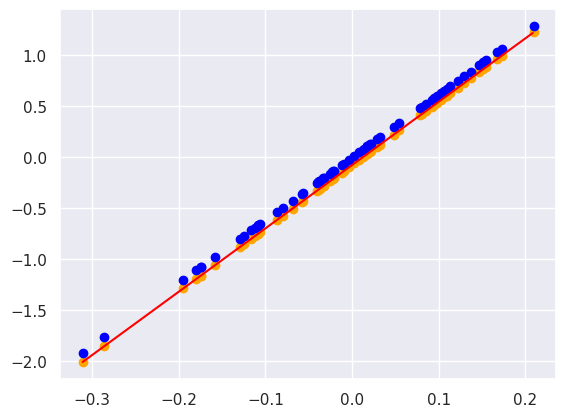

In [74]:
pred = predval[:,40].detach().numpy()
real = yval[:,40].detach().numpy()

m, b = np.polyfit(fcoord[:,0], pred.reshape(-1,1), 1)

#use red as color for regression line
x = np.arange(fcoord.min(),fcoord.max(),0.01)
plt.plot(x, m*x+b, color='red')

plt.scatter(fcoord, pred, color="orange")
plt.scatter(fcoord, real, color="blue")

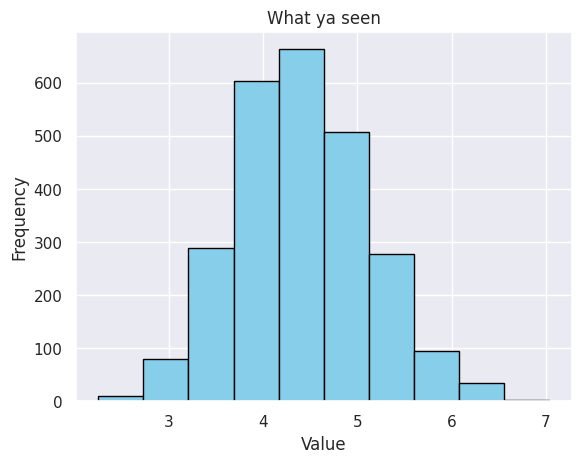

In [59]:
import numpy as np

# Plot histogram
plt.hist(torch.norm(xs[:,:40,:],dim=2).flatten(), bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('What ya seen')

# Show the plot
plt.show()

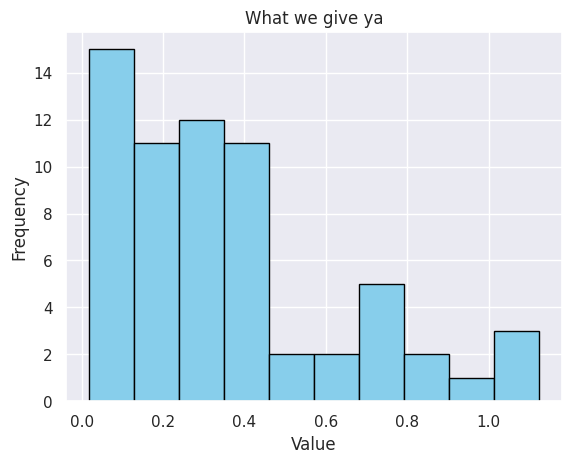

In [60]:
import numpy as np

# Plot histogram
plt.hist(torch.norm(fcoord * vec, dim=1).flatten(), bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('What we give ya')

# Show the plot
plt.show()